# Mid-Price LSTM

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, LSTM, TimeDistributed, GRU, SimpleRNN
from keras.models import Model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

## Data Pre-Processing

#### Import the data

In [81]:
file_1='./LOBs_Benchmark/Benchmark_Set01_2024-01-02LOBs.csv' #data generated using current mid trade prices, Y is current mid too

##### read the data_csv

In [82]:
data_original=pd.read_csv(file_1)
data_original.head(300)

,Time,Encode,Quoted_spread,Mid_Price,Weighted_Mid_Price,Best_bid_price,bid_volume,Best_ask_price,ask_volume,bid,...,"('level13', 'Ask', 'Price')","('level13', 'Ask', 'Volume')","('level14', 'Bid', 'Price')","('level14', 'Bid', 'Volume')","('level14', 'Ask', 'Price')","('level14', 'Ask', 'Volume')","('level15', 'Bid', 'Price')","('level15', 'Bid', 'Volume')","('level15', 'Ask', 'Price')","('level15', 'Ask', 'Volume')"
0,0.000,Exch0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.093,Exch0,239.0,119.5,NaN,NaN,NaN,239.0,2.0,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.240,Exch0,239.0,119.5,NaN,NaN,NaN,239.0,2.0,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.542,Exch0,238.0,120.0,179.500000,1.0,6.0,239.0,2.0,"[[1, 6]]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.666,Exch0,238.0,120.0,179.500000,1.0,6.0,239.0,2.0,"[[1, 6]]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,32.922,Exch0,1.0,253.5,253.769231,253.0,10.0,254.0,3.0,"[[253, 10], [252, 4], [251, 3], [249, 6], [244...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,32.953,Exch0,1.0,253.5,253.769231,253.0,10.0,254.0,3.0,"[[253, 10], [252, 6], [251, 3], [249, 6], [243...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297,32.984,Exch0,1.0,253.5,253.727273,253.0,8.0,254.0,3.0,"[[253, 8], [252, 6], [251, 3], [249, 6], [243,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,33.139,Exch0,1.0,253.5,253.727273,253.0,8.0,254.0,3.0,"[[253, 8], [252, 6], [251, 3], [249, 6], [243,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# Remove the single quotes for columns' names
data_original = data_original.rename(columns=lambda x: x.replace("'", ""))
data_original

,Time,Encode,Quoted_spread,Mid_Price,Weighted_Mid_Price,Best_bid_price,bid_volume,Best_ask_price,ask_volume,bid,...,"(level13, Ask, Price)","(level13, Ask, Volume)","(level14, Bid, Price)","(level14, Bid, Volume)","(level14, Ask, Price)","(level14, Ask, Volume)","(level15, Bid, Price)","(level15, Bid, Volume)","(level15, Ask, Price)","(level15, Ask, Volume)"
0,0.000,Exch0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.093,Exch0,239.0,119.5,NaN,NaN,NaN,239.0,2.0,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.240,Exch0,239.0,119.5,NaN,NaN,NaN,239.0,2.0,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.542,Exch0,238.0,120.0,179.5,1.0,6.0,239.0,2.0,"[[1, 6]]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.666,Exch0,238.0,120.0,179.5,1.0,6.0,239.0,2.0,"[[1, 6]]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333591,30599.604,Exch0,12.0,271.0,274.0,265.0,6.0,277.0,2.0,"[[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333592,30599.666,Exch0,12.0,271.0,274.0,265.0,6.0,277.0,2.0,"[[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333593,30599.697,Exch0,12.0,271.0,274.0,265.0,6.0,277.0,2.0,"[[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333594,30599.728,Exch0,12.0,271.0,274.0,265.0,6.0,277.0,2.0,"[[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Test if the data is a Gaussian distribution

(array([7.82940410e-06, 6.74198686e-06, 3.04476826e-06, 8.91682134e-06,
        1.41364241e-05, 2.19658282e-05, 5.89380142e-05, 1.15266227e-04,
        2.25095368e-04, 4.69372776e-03, 3.37973627e-02, 2.56169403e-02,
        3.06107952e-03, 1.57588506e-03, 8.01643986e-04, 6.33094315e-04,
        3.81900933e-04, 3.68634443e-04, 2.52933249e-04, 2.27705169e-04,
        1.76161592e-04, 1.17223578e-04, 1.23530598e-04, 8.56884782e-05,
        5.87205307e-05, 4.50190736e-05, 2.89252985e-05, 2.74029143e-05,
        4.13218550e-06, 1.17441061e-05]),
 array([119.5       , 133.28333333, 147.06666667, 160.85      ,
        174.63333333, 188.41666667, 202.2       , 215.98333333,
        229.76666667, 243.55      , 257.33333333, 271.11666667,
        284.9       , 298.68333333, 312.46666667, 326.25      ,
        340.03333333, 353.81666667, 367.6       , 381.38333333,
        395.16666667, 408.95      , 422.73333333, 436.51666667,
        450.3       , 464.08333333, 477.86666667, 491.65      ,
      

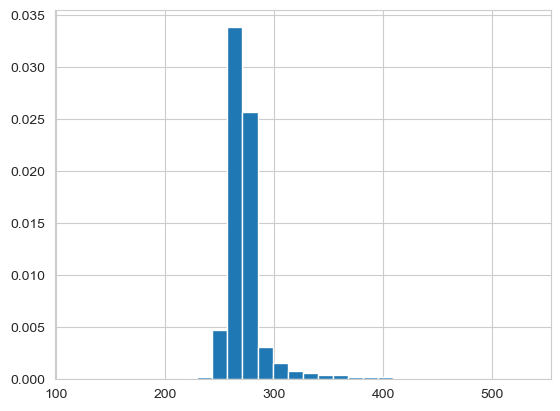

In [84]:
plt.hist(data_original['Mid_Price'], density=True,bins=30)

In [85]:
from scipy.stats import shapiro
# Perform Shapiro-Wilk test
stat, p = shapiro(data_original['Mid_Price'])

# Print test results
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Data follows a Gaussian distribution')
else:
    print('Data does not follow a Gaussian distribution')

Statistics=nan, p=1.000
Data follows a Gaussian distribution


/Users/yujiewang/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The data doesn't follow the rules of Gaussian distribution, so we use normalization not standardization

In [86]:
print(data_original.shape)

(333596, 71)


In [87]:
data_original.describe()

,Time,Quoted_spread,Mid_Price,Weighted_Mid_Price,Best_bid_price,bid_volume,Best_ask_price,ask_volume,"(level1, Bid, Price)","(level1, Bid, Volume)",...,"(level13, Ask, Price)","(level13, Ask, Volume)","(level14, Bid, Price)","(level14, Bid, Volume)","(level14, Ask, Price)","(level14, Ask, Volume)","(level15, Bid, Price)","(level15, Bid, Volume)","(level15, Ask, Price)","(level15, Ask, Volume)"
count,333596.000000,333595.000000,333595.000000,333571.000000,333586.000000,333586.000000,333580.000000,333580.000000,333586.000000,333586.000000,...,26.000000,26.000000,350.000000,350.000000,0.0,0.0,32.000000,32.000000,0.0,0.0
mean,15283.087245,17.672075,274.552268,275.593232,265.723397,4.704763,283.401052,2.952893,265.723397,4.704763,...,734.576923,2.923077,58.502857,3.591429,NaN,NaN,62.437500,5.593750,NaN,NaN
std,8857.467115,44.001796,23.899639,27.952276,10.881690,4.088475,44.571622,1.624569,10.881690,4.088475,...,34.411827,0.392232,43.149553,3.280827,NaN,NaN,28.977118,1.829144,NaN,NaN
min,0.000000,-274.000000,119.500000,100.000000,1.000000,1.000000,239.000000,1.000000,1.000000,1.000000,...,613.000000,1.000000,3.000000,1.000000,NaN,NaN,10.000000,2.000000,NaN,NaN
25%,7616.738750,3.000000,264.500000,264.777778,261.000000,2.000000,267.000000,2.000000,261.000000,2.000000,...,739.000000,3.000000,28.250000,1.000000,NaN,NaN,36.250000,5.000000,NaN,NaN
50%,15253.829000,6.000000,270.500000,270.625000,267.000000,3.000000,273.000000,3.000000,267.000000,3.000000,...,739.000000,3.000000,48.000000,2.000000,NaN,NaN,70.000000,5.500000,NaN,NaN
75%,22961.180750,11.000000,276.500000,277.000000,272.000000,6.000000,280.000000,4.000000,272.000000,6.000000,...,766.000000,3.000000,86.000000,4.750000,NaN,NaN,76.000000,6.000000,NaN,NaN
max,30599.945000,542.000000,533.000000,736.444444,284.000000,41.000000,796.000000,15.000000,284.000000,41.000000,...,766.000000,3.000000,172.000000,18.000000,NaN,NaN,141.000000,10.000000,NaN,NaN


### Pre-process the original data

1. About hot fill the 'NaN' value: 0 or inf ?

(1) Fill the volume with 0, and bid with -9999999999, ask with 9999999999
(2) Fill all of NaNs with 0

In [88]:
# Fill all of Nans with 0
data_original=data_original.fillna(0)

# Fill with -9999999
# max_level=15
# for i in range(max_level):
#     level="level"+str(i+1)
#     data_original['('+level+', Bid, Price)']=data_original['('+level+', Bid, Price)'].fillna(-9999999999)
#     data_original['('+level+', Bid, Volume)']=data_original['('+level+', Bid, Volume)'].fillna(0)
#     data_original['('+level+', Ask, Price)']=data_original['('+level+', Ask, Price)'].fillna(9999999999)
#     data_original['('+level+', Ask, Volume)']=data_original['('+level+', Ask, Volume)'].fillna(0)

In [89]:
data_original

,Time,Encode,Quoted_spread,Mid_Price,Weighted_Mid_Price,Best_bid_price,bid_volume,Best_ask_price,ask_volume,bid,...,"(level13, Ask, Price)","(level13, Ask, Volume)","(level14, Bid, Price)","(level14, Bid, Volume)","(level14, Ask, Price)","(level14, Ask, Volume)","(level15, Bid, Price)","(level15, Bid, Volume)","(level15, Ask, Price)","(level15, Ask, Volume)"
0,0.000,Exch0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.093,Exch0,239.0,119.5,0.0,0.0,0.0,239.0,2.0,[],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.240,Exch0,239.0,119.5,0.0,0.0,0.0,239.0,2.0,[],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.542,Exch0,238.0,120.0,179.5,1.0,6.0,239.0,2.0,"[[1, 6]]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.666,Exch0,238.0,120.0,179.5,1.0,6.0,239.0,2.0,"[[1, 6]]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333591,30599.604,Exch0,12.0,271.0,274.0,265.0,6.0,277.0,2.0,"[[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333592,30599.666,Exch0,12.0,271.0,274.0,265.0,6.0,277.0,2.0,"[[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333593,30599.697,Exch0,12.0,271.0,274.0,265.0,6.0,277.0,2.0,"[[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333594,30599.728,Exch0,12.0,271.0,274.0,265.0,6.0,277.0,2.0,"[[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2. Which columns should be dropped?

In [90]:
# Select the important columns
data=data_original.drop(columns=['Encode','Quoted_spread','Weighted_Mid_Price','Best_bid_price','bid_volume','Best_ask_price','ask_volume','bid','ask'])
data

,Time,Mid_Price,"(level1, Bid, Price)","(level1, Bid, Volume)","(level1, Ask, Price)","(level1, Ask, Volume)","(level2, Bid, Price)","(level2, Bid, Volume)","(level2, Ask, Price)","(level2, Ask, Volume)",...,"(level13, Ask, Price)","(level13, Ask, Volume)","(level14, Bid, Price)","(level14, Bid, Volume)","(level14, Ask, Price)","(level14, Ask, Volume)","(level15, Bid, Price)","(level15, Bid, Volume)","(level15, Ask, Price)","(level15, Ask, Volume)"
0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.093,119.5,0.0,0.0,239.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.240,119.5,0.0,0.0,239.0,2.0,0.0,0.0,248.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.542,120.0,1.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.666,120.0,1.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333591,30599.604,271.0,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333592,30599.666,271.0,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333593,30599.697,271.0,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333594,30599.728,271.0,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3. If I should do normalization for the data?

(1) Use the `MinMaxScaler` to normalize

In [91]:
# Do the normalization
from sklearn.preprocessing import MinMaxScaler

# get the names of columns
levels=[]
max_level=15
for i in range(max_level):
    levels.append("level"+str(i+1))
iterables=[levels,['Bid','Ask'],['Price','Volume']]
col_index=pd.MultiIndex.from_product(iterables)
col=np.concatenate([['Mid_Price'],col_index])

# MinMaxScaler
scaler = MinMaxScaler()
data_pro=data.drop(columns=['Time'])

data_normal_level=scaler.fit_transform(data_pro.to_numpy())
df_scaled = pd.DataFrame(data_normal_level, index=data.index,columns=col)
df_scaled = pd.merge(data['Time'],df_scaled, left_index=True,right_index=True)
df_scaled

,Time,Mid_Price,"(level1, Bid, Price)","(level1, Bid, Volume)","(level1, Ask, Price)","(level1, Ask, Volume)","(level2, Bid, Price)","(level2, Bid, Volume)","(level2, Ask, Price)","(level2, Ask, Volume)",...,"(level13, Ask, Price)","(level13, Ask, Volume)","(level14, Bid, Price)","(level14, Bid, Volume)","(level14, Ask, Price)","(level14, Ask, Volume)","(level15, Bid, Price)","(level15, Bid, Volume)","(level15, Ask, Price)","(level15, Ask, Volume)"
0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.093,0.224203,0.000000,0.000000,0.300251,0.133333,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.240,0.224203,0.000000,0.000000,0.300251,0.133333,0.000000,0.000000,0.31000,0.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.542,0.225141,0.003521,0.146341,0.300251,0.133333,0.000000,0.000000,0.31000,0.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.666,0.225141,0.003521,0.146341,0.300251,0.133333,0.000000,0.000000,0.31000,0.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333591,30599.604,0.508443,0.933099,0.146341,0.347990,0.133333,0.921986,0.195122,0.34875,0.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333592,30599.666,0.508443,0.933099,0.146341,0.347990,0.133333,0.921986,0.195122,0.34875,0.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333593,30599.697,0.508443,0.933099,0.146341,0.347990,0.133333,0.921986,0.195122,0.34875,0.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333594,30599.728,0.508443,0.933099,0.146341,0.347990,0.133333,0.921986,0.195122,0.34875,0.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
df_scaled.describe()

,Time,Mid_Price,"(level1, Bid, Price)","(level1, Bid, Volume)","(level1, Ask, Price)","(level1, Ask, Volume)","(level2, Bid, Price)","(level2, Bid, Volume)","(level2, Ask, Price)","(level2, Ask, Volume)",...,"(level13, Ask, Price)","(level13, Ask, Volume)","(level14, Bid, Price)","(level14, Bid, Volume)","(level14, Ask, Price)","(level14, Ask, Volume)","(level15, Bid, Price)","(level15, Bid, Volume)","(level15, Ask, Price)","(level15, Ask, Volume)"
count,333596.000000,333596.000000,333596.000000,333596.000000,333596.000000,333596.000000,333596.000000,333596.000000,333596.000000,333596.000000,...,333596.000000,333596.000000,333596.000000,333596.000000,333596.0,333596.0,333596.000000,333596.000000,333596.0,333596.0
mean,15283.087245,0.515106,0.935618,0.114747,0.356014,0.196850,0.924841,0.117183,0.386724,0.206333,...,0.000075,0.000076,0.000357,0.000209,0.0,0.0,0.000042,0.000054,0.0,0.0
std,8857.467115,0.044849,0.038656,0.099719,0.056047,0.108311,0.068903,0.102839,0.108093,0.114058,...,0.008475,0.008676,0.013678,0.008745,0.0,0.0,0.004768,0.005755,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
25%,7616.738750,0.496248,0.919014,0.048780,0.335427,0.133333,0.914894,0.048780,0.338750,0.133333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
50%,15253.829000,0.507505,0.940141,0.073171,0.342965,0.200000,0.936170,0.073171,0.347500,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
75%,22961.180750,0.518762,0.957746,0.146341,0.351759,0.266667,0.953901,0.146341,0.362500,0.266667,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
max,30599.945000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,0.0


(2) Use the Z-Score to normalize

In [93]:
data1=data.drop(columns=['Time','Mid_Price'])
from scipy.stats import zscore
normalised_data = data1.apply(zscore)
data1_Mid_Price=pd.DataFrame(normalised_data['(level1, Bid, Price)']+normalised_data['(level1, Ask, Price)']/2, columns=['Mid_Price'])
data_Time=data.Time
data1=pd.merge(data_Time,normalised_data,left_index=True, right_index=True)
data1=pd.merge(data1, data1_Mid_Price,left_index=True, right_index=True)
data1

,Time,"(level1, Bid, Price)","(level1, Bid, Volume)","(level1, Ask, Price)","(level1, Ask, Volume)","(level2, Bid, Price)","(level2, Bid, Volume)","(level2, Ask, Price)","(level2, Ask, Volume)","(level3, Bid, Price)",...,"(level13, Ask, Volume)","(level14, Bid, Price)","(level14, Bid, Volume)","(level14, Ask, Price)","(level14, Ask, Volume)","(level15, Bid, Price)","(level15, Bid, Volume)","(level15, Ask, Price)","(level15, Ask, Volume)",Mid_Price
0,0.000,-24.203622,-1.150700,-6.352031,-1.817462,-13.422459,-1.139485,-3.577717,-1.809025,-7.128566,...,-0.008753,-0.02609,-0.023937,NaN,NaN,-0.008909,-0.009324,NaN,NaN,-27.379638
1,0.093,-24.203622,-1.150700,-0.994929,-0.586433,-13.422459,-1.139485,-3.577717,-1.809025,-7.128566,...,-0.008753,-0.02609,-0.023937,NaN,NaN,-0.008909,-0.009324,NaN,NaN,-24.701087
2,1.240,-24.203622,-1.150700,-0.994929,-0.586433,-13.422459,-1.139485,-0.709801,0.528980,-7.128566,...,-0.008753,-0.02609,-0.023937,NaN,NaN,-0.008909,-0.009324,NaN,NaN,-24.701087
3,2.542,-24.112534,0.316835,-0.994929,-0.586433,-13.422459,-1.139485,-0.709801,0.528980,-7.128566,...,-0.008753,-0.02609,-0.023937,NaN,NaN,-0.008909,-0.009324,NaN,NaN,-24.609998
4,2.666,-24.112534,0.316835,-0.994929,-0.586433,-13.422459,-1.139485,-0.709801,0.528980,-7.128566,...,-0.008753,-0.02609,-0.023937,NaN,NaN,-0.008909,-0.009324,NaN,NaN,-24.609998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333591,30599.604,-0.065168,0.316835,-0.143173,-0.586433,-0.041435,0.757880,-0.351312,-1.224524,0.145493,...,-0.008753,-0.02609,-0.023937,NaN,NaN,-0.008909,-0.009324,NaN,NaN,-0.136754
333592,30599.666,-0.065168,0.316835,-0.143173,-0.586433,-0.041435,0.757880,-0.351312,-1.224524,0.145493,...,-0.008753,-0.02609,-0.023937,NaN,NaN,-0.008909,-0.009324,NaN,NaN,-0.136754
333593,30599.697,-0.065168,0.316835,-0.143173,-0.586433,-0.041435,0.757880,-0.351312,-1.224524,0.145493,...,-0.008753,-0.02609,-0.023937,NaN,NaN,-0.008909,-0.009324,NaN,NaN,-0.136754
333594,30599.728,-0.065168,0.316835,-0.143173,-0.586433,-0.041435,0.757880,-0.351312,-1.224524,0.145493,...,-0.008753,-0.02609,-0.023937,NaN,NaN,-0.008909,-0.009324,NaN,NaN,-0.136754


#### Plot the mid price

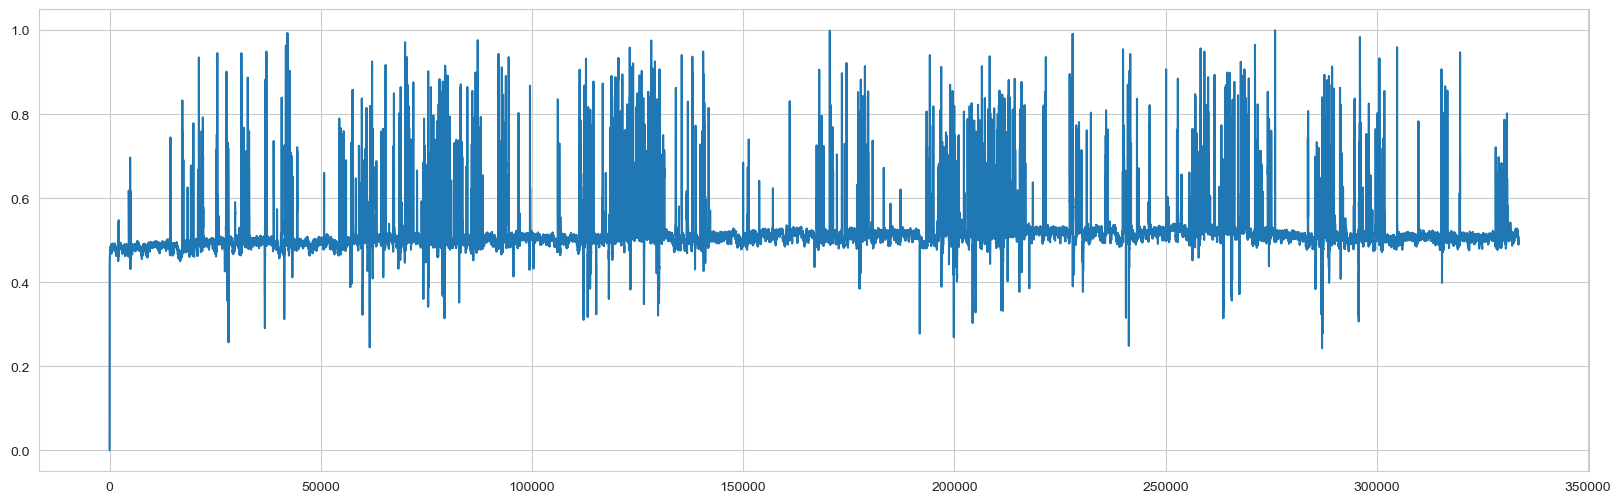

In [94]:
# MinmMaxscaler
plt.figure(figsize=(20,6))
plt.plot(df_scaled['Mid_Price'])

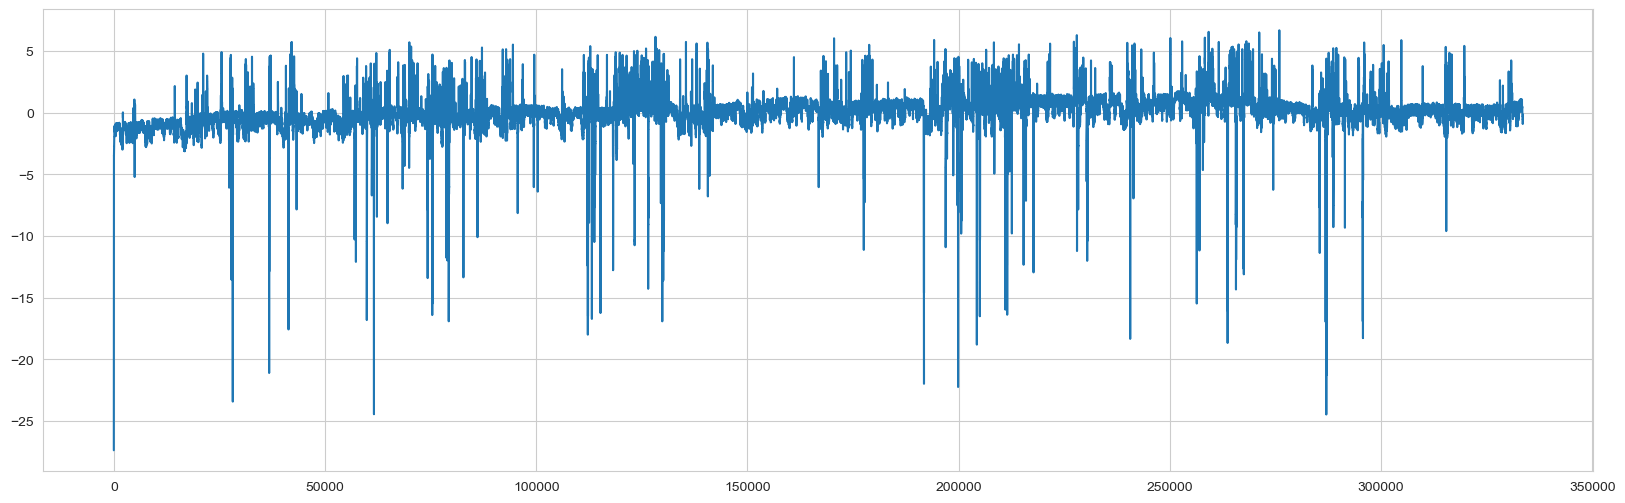

In [95]:
# Zscore
plt.figure(figsize=(20,6))
plt.plot(data1_Mid_Price)

### Split the data

In [131]:
df_scaled=data

In [132]:
from sklearn.model_selection import train_test_split
X=df_scaled.drop(columns=['Mid_Price'])
y=df_scaled['Mid_Price']
y = np.expand_dims(y, axis=1)
X_train,X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,shuffle=False)

print(len(X_train), len(y_train), len(X_test), len(y_test))

266876 266876 66720 66720


#### Set the batch

Batch size is important, any dependencies further apart from the Batch_size will not be taken into account. We could in theory give only one batch.

with the entire sequence but that will take an excessive amount of time to train and also the success is not guaranteed (vanishing gradient problem).

Question: How to find the best batch size?

In [133]:
def reshape_to_batches(a, batch_size):
    #pad if the length is not divisible by the batch_size
    batch_num = np.ceil(a.shape[0] / float(batch_size))
    modulo = batch_num * batch_size - a.shape[0]
    if modulo != 0:
        pad = np.zeros((int(modulo), a.shape[1]))
        a = np.vstack((a, pad))
    return np.array(np.split(a, batch_num))

In [134]:
batch_size = 30 #30 is about 165 minute (5.5min per ts x 30), tried 15 and a few other values too but 30 seems to be the best

X_train_batch = reshape_to_batches(X_train, batch_size)
y_train_batch = reshape_to_batches(y_train, batch_size)
print(X_train_batch.shape, y_train_batch.shape)

X_test_batch = reshape_to_batches(X_test, batch_size)
y_test_batch = reshape_to_batches(y_test, batch_size)
print(X_test_batch.shape, y_test_batch.shape)

(8896, 30, 61) (8896, 30, 1)
(2224, 30, 61) (2224, 30, 1)


## Create two baseline models, a LSTM and a GRU

### LSTM_MODEL1

[Time Distributed Layers](https://levelup.gitconnected.com/hands-on-practice-with-time-distributed-layers-using-tensorflow-c776a5d78e7e)

In [135]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [100]:
#Allows the network to accept batches of any size as input when predicting
# Make the model
model1 = Sequential()
model1.add(InputLayer((None, 61)))
lstm=LSTM(32,activation='tanh',recurrent_activation='hard_sigmoid', use_bias=True,
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
            recurrent_dropout=0.0, implementation=1, return_sequences=True, return_state=False,
            go_backwards=False, stateful=False, unroll=False)
model1.add(lstm)
model1.add(TimeDistributed(Dense(1, activation='linear')))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          12032     
                                                                 
 time_distributed (TimeDistr  (None, None, 1)          33        
 ibuted)                                                         
                                                                 
Total params: 12,065
Trainable params: 12,065
Non-trainable params: 0
_________________________________________________________________


In [101]:
# Compile the model
model1.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [102]:
# Fit the model
model1.fit(X_train_batch, y_train_batch, epochs=500)

Epoch 1/500


2023-04-24 11:43:13.013342: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


278/278 [==============================] - 2s 6ms/step - loss: 0.0030 - accuracy: 1.8735e-05
Epoch 2/500
278/278 [==============================] - 2s 5ms/step - loss: 0.0025 - accuracy: 1.8735e-05
Epoch 3/500
278/278 [==============================] - 2s 6ms/step - loss: 0.0025 - accuracy: 1.8735e-05
Epoch 4/500
278/278 [==============================] - 2s 6ms/step - loss: 0.0024 - accuracy: 1.8735e-05
Epoch 5/500
278/278 [==============================] - 2s 6ms/step - loss: 0.0024 - accuracy: 1.8735e-05
Epoch 6/500
278/278 [==============================] - 2s 5ms/step - loss: 0.0023 - accuracy: 1.8735e-05
Epoch 7/500
278/278 [==============================] - 1s 5ms/step - loss: 0.0023 - accuracy: 1.8735e-05
Epoch 8/500
278/278 [==============================] - 1s 5ms/step - loss: 0.0023 - accuracy: 1.8735e-05
Epoch 9/500
278/278 [==============================] - 1s 5ms/step - loss: 0.0022 - accuracy: 1.8735e-05
Epoch 10/500
278/278 [==============================] - 1s 5ms/step

In [103]:
# Predict the values
y_pred=model1.predict(X_test_batch)
print(y_pred.shape)

70/70 [==============================] - 0s 2ms/step
(2224, 30, 1)


#### Output the metrics

In [104]:
#linear
y_predict=y_pred.flatten()
print(mean_absolute_error(y_test,y_predict))
print(mean_squared_error(y_test,y_predict))

0.02251920087691639
0.001590580595682959


#### Plot the actual values and predictions

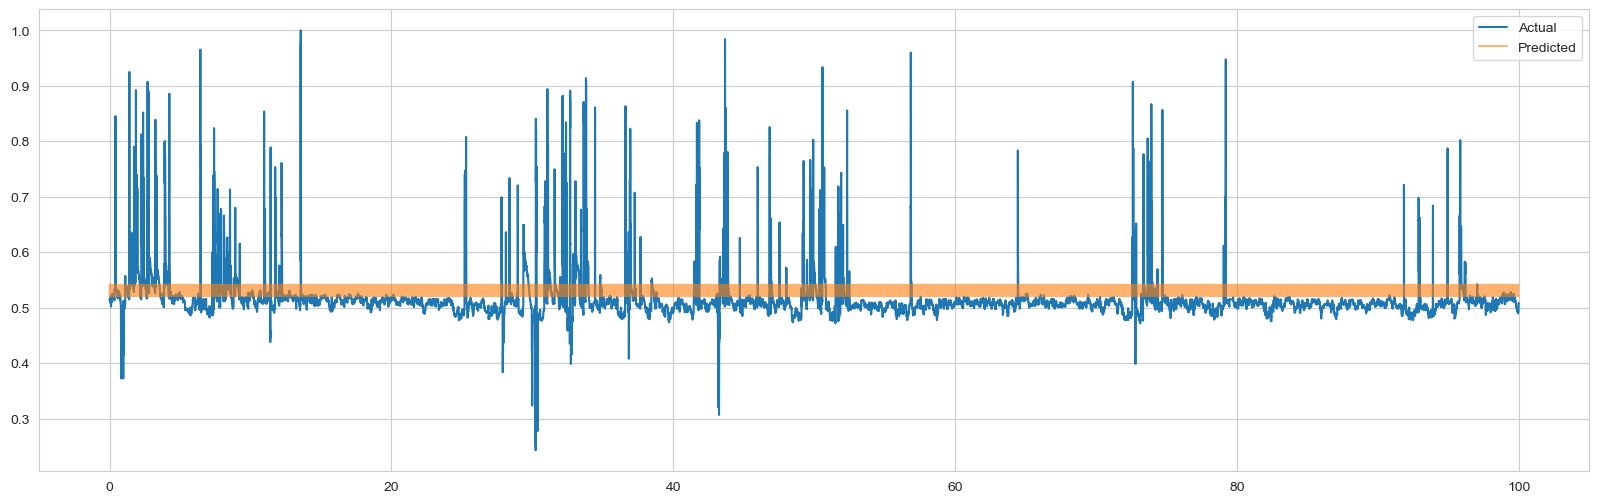

In [105]:
plt.figure(figsize=(20,6))
plt.plot(np.linspace(0, 100, len(y_test)), y_test, label='Actual')
plt.plot(np.linspace(0, 100, len(y_test)), y_predict, alpha=0.6, label='Predicted')
plt.legend()

### LSTM MODEL2

In [136]:
model2 = Sequential()
model2.add(InputLayer((None, 61)))
lstm=LSTM(32,activation='tanh',recurrent_activation='hard_sigmoid', use_bias=True,
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
            recurrent_dropout=0.0, implementation=1, return_sequences=True, return_state=False,
            go_backwards=False, stateful=False, unroll=False)
model2.add(lstm)
# use relu
model2.add(TimeDistributed(Dense(1, activation='relu')))
model2.summary()

model2.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

# Fit the model
model2.fit(X_train_batch, y_train_batch, epochs=500)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 32)          12032     
                                                                 
 time_distributed_2 (TimeDis  (None, None, 1)          33        
 tributed)                                                       
                                                                 
Total params: 12,065
Trainable params: 12,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
278/278 [==============================] - 2s 7ms/step - loss: 73896.2266 - accuracy: 0.0000e+00
Epoch 2/500
278/278 [==============================] - 2s 7ms/step - loss: 69709.3203 - accuracy: 0.0000e+00
Epoch 3/500
278/278 [==============================] - 2s 7ms/step - loss: 66057.7500 - accuracy: 0.0000e+00
Epoch 4/500
278/278 [==============================] 

In [137]:
#relu
y_pred = model2.predict(X_test_batch)
print(y_pred.shape)

70/70 [==============================] - 0s 2ms/step
(2224, 30, 1)


In [138]:
y_predict=y_pred.flatten()
print(mean_absolute_error(y_test, y_predict))
print(mean_squared_error(y_test, y_predict))

7.74815211193167
134.00731845083567


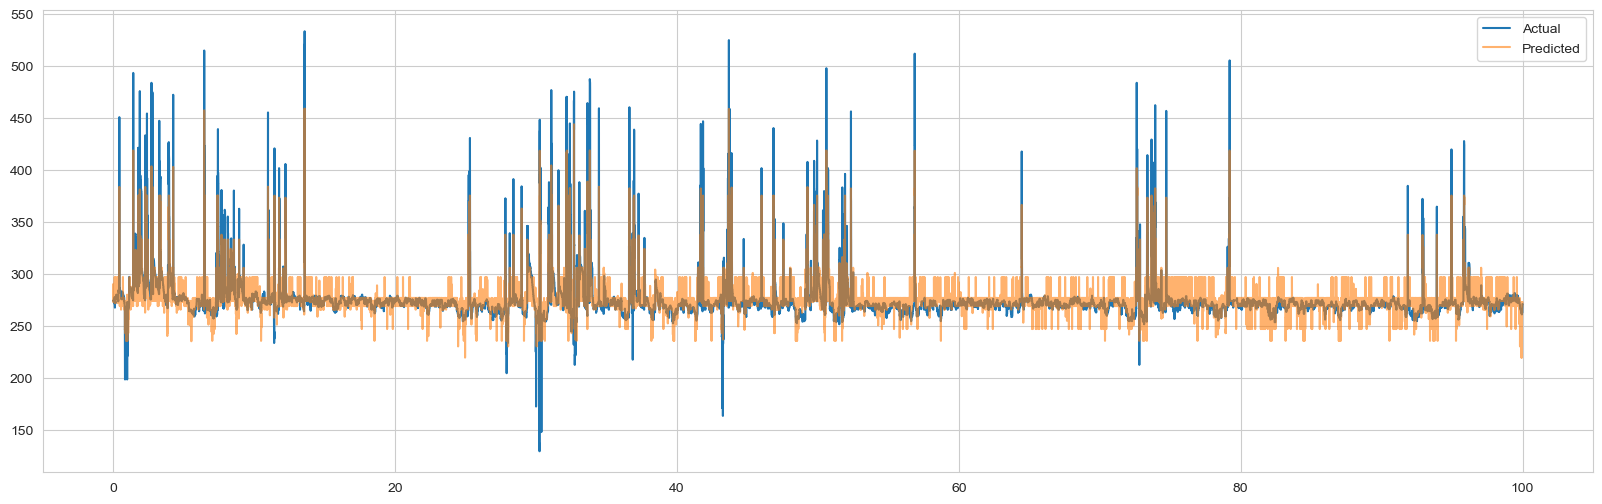

In [140]:
plt.figure(figsize=(20,6))
plt.plot(np.linspace(0, 100, len(y_test)), y_test, label='Actual')
plt.plot(np.linspace(0, 100, len(y_test)), y_predict2, alpha=0.6, label='Predicted')
plt.legend()

In [146]:
# with 128n, 500 epoch
y_predict2=y_pred.flatten()
print(mean_absolute_error(y_test.flatten(), y_predict2))
print(mean_squared_error(y_test.flatten(), y_predict2))

7.74815211193167
134.00731845083567


In [148]:
# y_test_tran=y_test.reshape(-1,1)
# y_predict2_tran=y_predict2.reshape(-1,1)
# scaler2=MinMaxScaler()
# dataMid=data.Mid_Price
# datatrans=dataMid.to_numpy()
# datatrans=datatrans.reshape(-1,1)
#
# midprice=scaler2.fit_transform(datatrans)
# unscaled_y_test=scaler2.inverse_transform(y_test_tran).flatten()
# unscaled_y_predict=scaler2.inverse_transform(y_predict2_tran).flatten()
# df_test=pd.DataFrame(data={'Test Predictions':unscaled_y_predict,'Actual values:': unscaled_y_test })
df_test=pd.DataFrame(data={'Test Predictions':y_predict2,'Actual values:': y_test.flatten() })
df_test

[[274.5]
 [274.5]
 [274.5]
 ...
 [271. ]
 [271. ]
 [271. ]]
[274.0544  290.31516 275.73114 ... 272.77847 272.77914 272.77914]


,Test Predictions,Actual values:
0,274.054413,274.5
1,290.315155,274.5
2,275.731140,274.5
3,276.466675,274.5
4,276.762726,274.5
...,...,...
66715,272.706543,271.0
66716,272.767700,271.0
66717,272.778473,271.0
66718,272.779144,271.0


## Models for Mid-price classification

Whether the next price goes up, down or remains constant

### Get the Next Mid and Price Move

<Axes: >

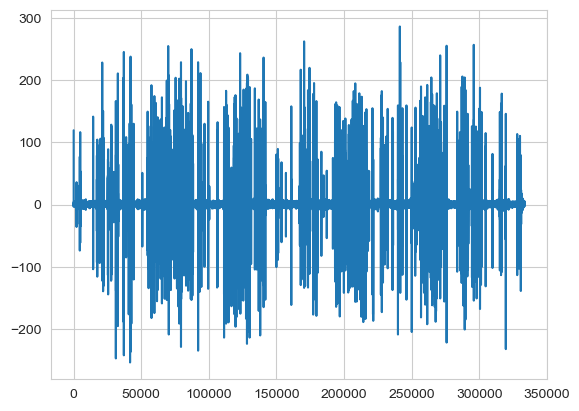

In [158]:
# Use scaled data
df_scaled['Next_mid']=df_scaled.Mid_Price.shift(-1)
df_scaled.dropna(axis=0, inplace=True) #drop the last row which is now Nan
df_scaled['Price_move'] = df_scaled.Next_mid - df_scaled.Mid_Price

df_scaled.Price_move.plot()

In [159]:
# down: <0, up: >0, stationary: 0
print(df_scaled[df_scaled['Price_move'] < 0].Time.count(), df_scaled[df_scaled['Price_move'] == 0].Time.count(), df_scaled[df_scaled['Price_move'] > 0].Time.count())

41556 268902 23136


In [160]:
df_scaled['up_or_down'] = np.where(df_scaled['Price_move']<0, 0, 1) #for now defining Price_move=0 as 1
df_scaled.head(8)

,Time,Mid_Price,"(level1, Bid, Price)","(level1, Bid, Volume)","(level1, Ask, Price)","(level1, Ask, Volume)","(level2, Bid, Price)","(level2, Bid, Volume)","(level2, Ask, Price)","(level2, Ask, Volume)",...,"(level14, Bid, Volume)","(level14, Ask, Price)","(level14, Ask, Volume)","(level15, Bid, Price)","(level15, Bid, Volume)","(level15, Ask, Price)","(level15, Ask, Volume)",Next_mid,Price_move,up_or_down
0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.5,119.5,1
1,0.093,119.5,0.0,0.0,239.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.5,0.0,1
2,1.240,119.5,0.0,0.0,239.0,2.0,0.0,0.0,248.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.5,1
3,2.542,120.0,1.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.0,1
4,2.666,120.0,1.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.5,0.5,1
5,2.728,120.5,2.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.5,0.0,1
6,3.720,120.5,2.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.5,0.0,1
7,3.937,120.5,2.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.5,0.0,1


In [161]:
df_scaled.drop(['Mid_Price', 'Next_mid', 'Price_move'], axis=1, inplace=True) #deleting Mid and the other extra columns

In [162]:
df_scaled

,Time,"(level1, Bid, Price)","(level1, Bid, Volume)","(level1, Ask, Price)","(level1, Ask, Volume)","(level2, Bid, Price)","(level2, Bid, Volume)","(level2, Ask, Price)","(level2, Ask, Volume)","(level3, Bid, Price)",...,"(level13, Ask, Volume)","(level14, Bid, Price)","(level14, Bid, Volume)","(level14, Ask, Price)","(level14, Ask, Volume)","(level15, Bid, Price)","(level15, Bid, Volume)","(level15, Ask, Price)","(level15, Ask, Volume)",up_or_down
0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.093,0.0,0.0,239.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1.240,0.0,0.0,239.0,2.0,0.0,0.0,248.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2.542,1.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2.666,1.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333589,30599.480,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,257.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
333590,30599.573,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,257.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
333591,30599.604,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,257.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
333592,30599.666,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,257.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Split the data

`to_categorical`: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

In [163]:
#using all samples
X_y = df_scaled.values
y = np.expand_dims(X_y[:, -1], axis=1) #is binary and needs to change to categorical instead of scaling
X = X_y[:,:-1]

In [164]:
from tensorflow.keras.utils import to_categorical
y_binary = to_categorical(y)
print(y_binary.shape)

(333594, 2)


In [165]:
X_train,X_test, y_train, y_test = train_test_split(X, y_binary,test_size=0.2,shuffle=False)

print(len(X_train), len(y_train), len(X_test), len(y_test))

266875 266875 66719 66719


### Split to the batches

In [166]:
batch_size = 30

X_train_batch = reshape_to_batches(X_train, batch_size)
y_train_batch = reshape_to_batches(y_train, batch_size)
print(X_train_batch.shape, y_train_batch.shape)

X_test_batch = reshape_to_batches(X_test, batch_size)
y_test_batch = reshape_to_batches(y_test, batch_size)
print(X_test_batch.shape, y_test_batch.shape)

(8896, 30, 61) (8896, 30, 2)
(2224, 30, 61) (2224, 30, 2)


### Creating a simple RNN classifier

In [167]:
def classification_result(y_pred, thresh=0.5):
  cutt_off_tr = thresh # some threshold

  y_pred[np.where(y_pred >= cutt_off_tr)] = 1
  y_pred[np.where(y_pred < cutt_off_tr)]  = 0

  print(confusion_matrix(
         y_test_batch.flatten(), y_pred.flatten()))

  print()
  print(classification_report(
          y_test_batch.flatten(),
          y_pred.flatten(),
          target_names = ["Down", "Up"],
          digits = 5))

In [168]:
model_rnn=Sequential()
model_rnn.add(InputLayer((batch_size,61)))
rnn = SimpleRNN(128, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
                bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None,
                activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
                recurrent_dropout=0.0, return_sequences=True, return_state=False, go_backwards=False, stateful=False, unroll=False)
model_rnn.add(rnn)
model_rnn.add(TimeDistributed(Dense(2,activation='softmax')))
model_rnn.summary()
model_rnn.compile(optimizer='rmsprop', #learning rate algo
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 30, 128)           24320     
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 2)            258       
 tributed)                                                       
                                                                 
Total params: 24,578
Trainable params: 24,578
Non-trainable params: 0
_________________________________________________________________


In [169]:
model_rnn.fit(X_train_batch, y_train_batch, epochs=500)

Epoch 1/500
278/278 [==============================] - 1s 4ms/step - loss: 0.4187 - accuracy: 0.8564
Epoch 2/500
278/278 [==============================] - 1s 4ms/step - loss: 0.3842 - accuracy: 0.8734
Epoch 3/500
278/278 [==============================] - 1s 4ms/step - loss: 0.3832 - accuracy: 0.8734
Epoch 4/500
278/278 [==============================] - 1s 4ms/step - loss: 0.3828 - accuracy: 0.8734
Epoch 5/500
278/278 [==============================] - 1s 4ms/step - loss: 0.3826 - accuracy: 0.8734
Epoch 6/500
278/278 [==============================] - 1s 4ms/step - loss: 0.3827 - accuracy: 0.8734
Epoch 7/500
278/278 [==============================] - 1s 4ms/step - loss: 0.3823 - accuracy: 0.8734
Epoch 8/500
278/278 [==============================] - 1s 4ms/step - loss: 0.3816 - accuracy: 0.8734
Epoch 9/500
278/278 [==============================] - 1s 4ms/step - loss: 0.3816 - accuracy: 0.8734
Epoch 10/500
278/278 [==============================] - 1s 4ms/step - loss: 0.3822 - accura

In [171]:
y_pred = model_rnn.predict(X_test_batch)
classification_result(y_pred)

70/70 [==============================] - 0s 2ms/step
[[58939  7782]
 [ 7781 58938]]

              precision    recall  f1-score   support

        Down    0.88338   0.88337   0.88337     66721
          Up    0.88336   0.88338   0.88337     66719

    accuracy                        0.88337    133440
   macro avg    0.88337   0.88337   0.88337    133440
weighted avg    0.88337   0.88337   0.88337    133440



You need do the optimization here !!

### Do Big Move Classification (-0.00025 < price move < 0.00025):

Change the range value: K

In [287]:
ALPHA=0.001
K=10

In [288]:
data=data_original.drop(columns=['Encode','Quoted_spread','Weighted_Mid_Price','Best_bid_price','bid_volume','Best_ask_price','ask_volume','bid','ask'])
df_class=data.drop(columns=['Mid_Price'])
df_class

,Time,"(level1, Bid, Price)","(level1, Bid, Volume)","(level1, Ask, Price)","(level1, Ask, Volume)","(level2, Bid, Price)","(level2, Bid, Volume)","(level2, Ask, Price)","(level2, Ask, Volume)","(level3, Bid, Price)",...,"(level13, Ask, Price)","(level13, Ask, Volume)","(level14, Bid, Price)","(level14, Bid, Volume)","(level14, Ask, Price)","(level14, Ask, Volume)","(level15, Bid, Price)","(level15, Bid, Volume)","(level15, Ask, Price)","(level15, Ask, Volume)"
0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.093,0.0,0.0,239.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.240,0.0,0.0,239.0,2.0,0.0,0.0,248.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.542,1.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.666,1.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333591,30599.604,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,257.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333592,30599.666,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,257.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333593,30599.697,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,257.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333594,30599.728,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,257.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [312]:
# normalised_data = df_class.drop(columns=['Time']).apply(zscore)
normalised_data=df_class.drop(columns=['Time'])
df_time=df_class.Time
normalised_data=pd.merge(df_time,normalised_data, left_index=True, right_index=True)
normalised_data['midprice'] = (normalised_data['(level1, Ask, Price)']+normalised_data['(level1, Bid, Price)'])/2
# mean of previous k mid-prices
normalised_data['m_minus'] = normalised_data['midprice'].rolling(window=K).mean()
    # mean of next k mid-prices
normalised_data['m_plus'] = normalised_data['midprice'][::-1].rolling(window=K).mean()[::-1]
normalised_data

,Time,"(level1, Bid, Price)","(level1, Bid, Volume)","(level1, Ask, Price)","(level1, Ask, Volume)","(level2, Bid, Price)","(level2, Bid, Volume)","(level2, Ask, Price)","(level2, Ask, Volume)","(level3, Bid, Price)",...,"(level14, Bid, Volume)","(level14, Ask, Price)","(level14, Ask, Volume)","(level15, Bid, Price)","(level15, Bid, Volume)","(level15, Ask, Price)","(level15, Ask, Volume)",midprice,m_minus,m_plus
0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,108.20
1,0.093,0.0,0.0,239.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.5,NaN,120.30
2,1.240,0.0,0.0,239.0,2.0,0.0,0.0,248.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.5,NaN,120.45
3,2.542,1.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,NaN,120.65
4,2.666,1.0,6.0,239.0,2.0,0.0,0.0,248.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,NaN,120.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333591,30599.604,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,257.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,271.0,266.5,NaN
333592,30599.666,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,257.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,271.0,267.3,NaN
333593,30599.697,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,257.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,271.0,268.1,NaN
333594,30599.728,265.0,6.0,277.0,2.0,260.0,8.0,279.0,1.0,257.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,271.0,268.9,NaN


In [313]:
normalised_data['change'] = (normalised_data.m_plus - normalised_data.m_minus)/normalised_data.m_minus
# assign categories up, down, stationary
normalised_data['label'] = pd.cut(normalised_data.change, bins=[-np.inf, -ALPHA, ALPHA, np.inf], labels=['down', 'stationary', 'up'])
# drop all unlabelled values (will be first and last k values as they have no m_minus/m_plus value)
normalised_data.dropna(subset=['label'],inplace=True)
# normalised_data.dropna(inplace=True)
normalised_data

,Time,"(level1, Bid, Price)","(level1, Bid, Volume)","(level1, Ask, Price)","(level1, Ask, Volume)","(level2, Bid, Price)","(level2, Bid, Volume)","(level2, Ask, Price)","(level2, Ask, Volume)","(level3, Bid, Price)",...,"(level14, Ask, Volume)","(level15, Bid, Price)","(level15, Bid, Volume)","(level15, Ask, Price)","(level15, Ask, Volume)",midprice,m_minus,m_plus,change,label
9,4.681,3.0,6.0,239.0,2.0,0.0,0.0,243.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,121.0,108.20,121.65,0.124307,up
10,5.611,3.0,6.0,239.0,2.0,0.0,0.0,243.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,121.0,120.30,121.85,0.012884,up
11,5.704,3.0,6.0,239.0,2.0,0.0,0.0,243.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,121.0,120.45,122.05,0.013284,up
12,5.890,4.0,6.0,239.0,2.0,0.0,0.0,243.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,121.5,120.65,122.70,0.016991,up
13,6.014,4.0,6.0,239.0,2.0,0.0,0.0,243.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,121.5,120.80,123.35,0.021109,up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333582,30598.860,260.0,8.0,266.0,2.0,257.0,7.0,267.0,2.0,170.0,...,0.0,0.0,0.0,0.0,0.0,263.0,262.65,266.50,0.014658,up
333583,30598.891,260.0,8.0,266.0,2.0,257.0,7.0,267.0,2.0,69.0,...,0.0,0.0,0.0,0.0,0.0,263.0,262.70,267.30,0.017510,up
333584,30599.046,260.0,8.0,266.0,2.0,257.0,7.0,267.0,2.0,89.0,...,0.0,0.0,0.0,0.0,0.0,263.0,262.75,268.10,0.020362,up
333585,30599.139,260.0,8.0,266.0,2.0,257.0,7.0,267.0,2.0,89.0,...,0.0,0.0,0.0,0.0,0.0,263.0,262.80,268.90,0.023212,up


<Axes: >

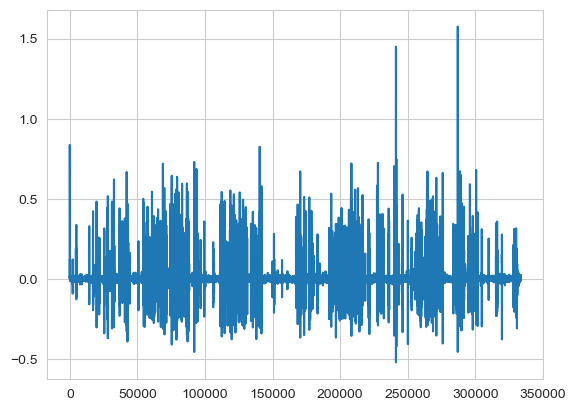

In [314]:
normalised_data['change'].plot()

#### Using ConvRNN

In [315]:
# Static objects
from sklearn.preprocessing import OneHotEncoder
# instantiate one hot encoder here so that all classes will always map to the same labels
onehot_encoder = OneHotEncoder(sparse=False)

In [316]:
def reshape_and_categorise_data(normalised_data,step):
    n = len(normalised_data) - len(normalised_data)%step
    data = normalised_data[:n]

    # reshape input data into the shape of (batches, 100, 40, 1) as one input has 100 timesteps with 40 features
    input_data = data.drop(columns=['Time','change','m_minus','m_plus','label','midprice'])
    input_array = input_data.to_numpy().reshape(n//step,step,60,1)

    # choose every 100th value as the output label/ 100 timesteps predict the 100th price move direction
    output_data = data.label.to_numpy()[::-step][::-1]

    # encode labels to vectors
    integer_encoded = output_data.reshape(len(output_data), 1)
    output_array = onehot_encoder.fit_transform(integer_encoded)

    return input_array, output_array

In [317]:
X,y=reshape_and_categorise_data(normalised_data,100)
print(X.shape)
print(y.shape)

(3335, 100, 60, 1)
(3335, 3)


/Users/yujiewang/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [318]:
X_train,X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,shuffle=False)

print(len(X_train), len(y_train), len(X_test), len(y_test))

2668 2668 667 667


In [319]:
print(X_train.shape)

(2668, 100, 60, 1)


#### Create the Model

In [330]:
LEARNING_RATE=0.01
EPOCHS = 500

In [324]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense,LeakyReLU,MaxPooling2D,Dropout

In [325]:
# convolutional layers
model_mid = Sequential()
model_mid.add(Conv2D(filters=16, kernel_size=(1,2), input_shape=(100,60,1),strides=(1, 2)))
model_mid.add(LeakyReLU(alpha=0.01))
model_mid.add(Conv2D(filters=32, kernel_size=(4,1)))
#     model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))

model_mid.add(Conv2D(filters=16, kernel_size=(1,2), strides=(1, 2)))
model_mid.add(LeakyReLU(alpha=0.01))
model_mid.add(Conv2D(filters=32, kernel_size=(4,1)))
#     model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))

model_mid.add(Conv2D(filters=16, kernel_size=(1,10), input_shape=(100,10,1)))
model_mid.add(Conv2D(filters=32, kernel_size=(4,1)))
#     model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))

model_mid.add(MaxPooling2D(pool_size=(3,1)))
model_mid.add(TimeDistributed(Flatten()))

# lstm layer
model_mid.add(SimpleRNN(100))
model_mid.add(Dropout(0.50))
model_mid.add(Dense(3,activation='softmax'))
# compile model and summarize
adam = Adam(lr=LEARNING_RATE, epsilon=1)
model_mid.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_mid.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 30, 16)       48        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 30, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 30, 32)        2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 97, 15, 16)        1040      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 97, 15, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 15, 32)        2080      
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 6, 16)       

/Users/yujiewang/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [332]:
history=model_mid.fit(X_train,y_train, epochs=EPOCHS, batch_size=100)

Epoch 1/500
27/27 [==============================] - 2s 74ms/step - loss: 0.9011 - accuracy: 0.5821
Epoch 2/500
27/27 [==============================] - 2s 74ms/step - loss: 0.9043 - accuracy: 0.5757
Epoch 3/500
27/27 [==============================] - 2s 71ms/step - loss: 0.9070 - accuracy: 0.5768
Epoch 4/500
27/27 [==============================] - 2s 72ms/step - loss: 0.9056 - accuracy: 0.5735
Epoch 5/500
27/27 [==============================] - 2s 71ms/step - loss: 0.8933 - accuracy: 0.5806
Epoch 6/500
27/27 [==============================] - 2s 70ms/step - loss: 0.9036 - accuracy: 0.5720
Epoch 7/500
27/27 [==============================] - 2s 70ms/step - loss: 0.8951 - accuracy: 0.5866
Epoch 8/500
27/27 [==============================] - 2s 79ms/step - loss: 0.9020 - accuracy: 0.5828
Epoch 9/500
27/27 [==============================] - 2s 70ms/step - loss: 0.9061 - accuracy: 0.5731
Epoch 10/500
27/27 [==============================] - 2s 70ms/step - loss: 0.8976 - accuracy: 0.5840

In [333]:
score, accuracy = model_mid.evaluate(X_test, y_test, batch_size=100)
print("Accuracy is {}%".format(accuracy*100))

7/7 [==============================] - 0s 24ms/step - loss: 2.0810 - accuracy: 0.4078
Accuracy is 40.779611468315125%


Text(0, 0.5, 'Loss')

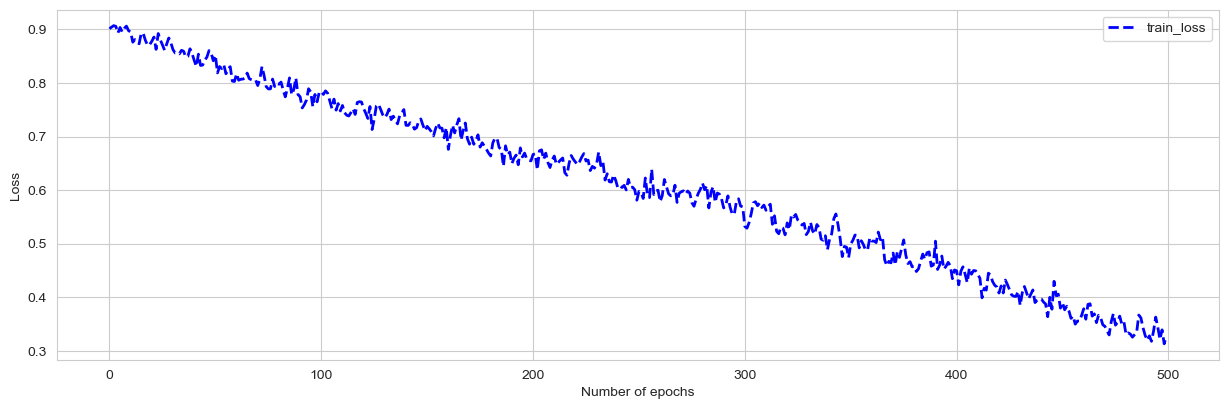

In [336]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
# plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
# plt.ylim([.5,1.3])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
# plt.subplot(2,1,2)
# plt.plot(history.history['acc'],'b--',lw=2,label='train_acc')
# # plt.plot(history.history['val_acc'],'g-',lw=2,label='val_acc')
# plt.legend()
# # plt.ylim([.2,1.0])
# plt.xlabel('Number of epochs')
# plt.ylabel('Accuracy')
# plt.show()

In [337]:
# mapping of labels to one hot encoding
import json
def get_mapping(write_data):
    if write_data:
        encodings = [[1,0,0],[0,0,1],[0,1,0]]
        mapping = {str(np.argmax(key)):onehot_encoder.inverse_transform([key]).tolist()[0][0] for key in encodings}
        with open('./mapping.txt', 'w') as file:
            file.write(json.dumps(mapping))
        return mapping
    else:
        with open('./mapping.txt', 'r') as f:
            mapping = f.read()
        return mapping

In [338]:
write_data=True
mapping = get_mapping(write_data)
print(mapping)

{'0': 'down', '2': 'up', '1': 'stationary'}


In [339]:
target_names = [mapping[str(i)] for i in range(3)]
y_pred = model_mid.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)
print(classification_report(y_pred_bool, y_test_bool, target_names=target_names))
print(confusion_matrix(y_test_bool, y_pred_bool, labels=[0,1,2]))

21/21 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

        down       0.59      0.46      0.51       360
  stationary       0.14      0.27      0.19        89
          up       0.38      0.38      0.38       218

    accuracy                           0.41       667
   macro avg       0.37      0.37      0.36       667
weighted avg       0.46      0.41      0.43       667

[[165  39  77]
 [ 88  24  58]
 [107  26  83]]


In [340]:
print("Accuracy is {}%".format(accuracy*100))

Accuracy is 40.779611468315125%


#### Using LSTM (Not well)